<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/02_download_metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Dependencies

In [ ]:
!pip install holidays
%cd /content/drive/MyDrive/opportunistic-utm/

# Check DarkSky API

In [9]:
# Checks API using a random timestamp
timestamp = 1546339684
key = '00fa20d9a815fab822b59c022ba8f4e5'
location = '51.87626460000001,-0.3717470999999932'
exclude = 'exclude=minutely,hourly,daily,alerts,flags'
units = 'si'
endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
requests.get(endpoint).json()['currently']

{'apparentTemperature': 5.4,
 'cloudCover': 0.75,
 'dewPoint': 5.95,
 'humidity': 0.82,
 'temperature': 8.86,
 'time': 1546339684,
 'uvIndex': 0,
 'visibility': 10.003,
 'windBearing': 288,
 'windSpeed': 26.11}

# Define Metadata Functions

In [5]:
from datetime import datetime
import numpy as np
import holidays
import math
import requests

def epoch_to_utc(hour_in_unix_time):
  return datetime.utcfromtimestamp(hour_in_unix_time)

def get_month(unix_timestamp):
  return unix_timestamp.month

def get_day(unix_timestamp):
  return unix_timestamp.weekday()

def is_holiday(timestamp):
  uk_holidays = holidays.UK()

  if timestamp in uk_holidays:
    return 1
  else:
    return 0

def rescale(val, in_min, in_max, out_min, out_max):
  return out_min + (val - in_min) * ((out_max - out_min) / (in_max - in_min))

# Gets weather information using DarkSky API
def get_weather(unix_timestamp, size = 100):
  timestamp = str(unix_timestamp)
  key = '00fa20d9a815fab822b59c022ba8f4e5'
  location = '51.87626460000001,-0.3717470999999932'
  exclude = 'exclude=minutely,hourly,daily,alerts,flags'
  units = 'si'
  endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
  response = requests.get(endpoint).json()['currently']

  try:
    temperature = np.reshape(rescale(response['temperature'], -30, 30, 0, 1), (1,1))
  except:
    temperature = np.reshape(rescale(0, -30, 30, 0, 1), (1,1))

  try:
    wind_bearing = np.reshape(response['windBearing']/360, (1,1))
  except:
    wind_bearing = np.reshape(0, (1,1))

  try:
    wind_speed = np.reshape(rescale(response['windSpeed'], 0, 30, 0, 1), (1,1))
  except:
    wind_speed = np.reshape(rescale(0, 0, 30, 0, 1), (1,1))

  try:
    visibility = np.reshape(rescale(response['visibility'], 0, 20, 0, 1), (1,1))
  except:
    visibility = np.reshape(rescale(0, 0, 20, 0, 1), (1,1))

  try:
    cloud_cover = np.reshape(rescale(response['cloudCover'], 0, 1, 0, 1), (1,1))
  except:
    cloud_cover = np.reshape(rescale(0, 0, 1, 0, 1), (1,1))

  weather_metadata = np.concatenate((temperature, wind_bearing, wind_speed, visibility, cloud_cover), axis = 1)
  return np.tile(weather_metadata, (size, 1))

def spacer(units):
  return np.zeros(units)

def metadata(timestamp, size = 100, tiled = False):
  utc_timestamp = epoch_to_utc(timestamp)

  # Hot-encode day and month
  months = np.zeros(12)
  days = np.zeros(7)
  months[get_month(utc_timestamp)-1] = 1
  days[get_day(utc_timestamp)] = 1
  months_tile = np.tile(months, (size, 1))
  days_tile = np.tile(days, (size, 1))

  # Hot-enconde if holiday is true
  holiday_tile = np.tile(is_holiday(utc_timestamp), (size, 1))

  # Weather
  weather_tile = get_weather(timestamp, size=size)

  # Spacer if needed
  spacer_tile = np.tile(spacer(1), (size, 1))

  tiled_metadata = np.concatenate((months_tile, days_tile, holiday_tile, weather_tile), axis = 1)

  # Merge together
  if tiled == True:
    width = math.ceil(size/tiled_metadata.shape[-1])
    tiled_metadata = np.tile(tiled_metadata, width)[:,:size]
    return tiled_metadata
  elif tiled == False:
    return tiled_metadata[0]

# Test Sample

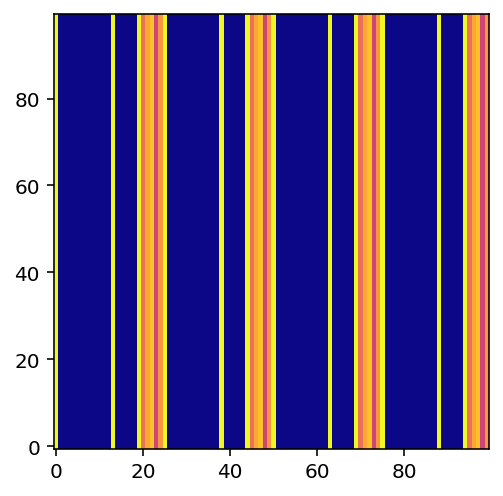

In [7]:
# Plot as a tile of (100, 100)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plot_metadata = metadata(1546339684, tiled = True)
plt.imshow(plot_metadata, origin='lower', cmap='plasma')
plt.show()

In [6]:
# Check metadata shape
metadata(1655991661).shape

(25,)

# Download Metadata

In [ ]:
from datetime import timezone
from datetime import datetime
from tqdm import tqdm
import numpy as np
import os

# Download data manually as needed
year = 2019
month = 9
days = np.linspace(1,31,31)

# Iterates through each day in a given month
for day in tqdm(days):
  unix_hour = int(datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp())
  for i in range(0, 24):
    str_year = str(year)
    str_month = str(month).zfill(2)
    str_day = str(int(day)).zfill(2)
    saving_folder = f'/dataset/{str_year}-{str_month}/{str_year}-{str_month}-{str_day}/metadata'

    if not os.path.exists(f'{saving_folder}'):
      os.makedirs(f'{saving_folder}')

    np.save(f'{saving_folder}/{str(unix_hour)}.npy', metadata(unix_hour))
    unix_hour += 3600